# Predicting BitCoin prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
# Change Keras backend
from keras import backend as K
import os
os.environ['KERAS_BACKEND'] = "cntk"

In [2]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# 1. Get historic stock prices
data = pd.read_csv("../datasets/BTC/gemini_BTCUSD_day.csv")

# Data review

In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.642390e+12,17/01/2022 04:00,BTCUSD,42655.12,42976.61,41559.11,42236.96,556.178715
1,1.642310e+12,16/01/2022 04:00,BTCUSD,43022.38,43499.99,42583.00,42655.12,622.078099
2,1.642220e+12,15/01/2022 04:00,BTCUSD,42947.72,43811.44,42590.52,43022.38,850.111677
3,1.642130e+12,14/01/2022 04:00,BTCUSD,42679.68,43462.53,41789.82,42947.72,800.802511
4,1.642050e+12,13/01/2022 04:00,BTCUSD,43525.85,44443.94,42326.63,42679.68,1120.790154


In [5]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
2289,1.444622e+09,12/10/2015 04:00,BTCUSD,248.98,248.98,245.75,245.75,71.047743
2290,1.444536e+09,11/10/2015 04:00,BTCUSD,246.30,249.50,245.96,248.98,22.747091
2291,1.444450e+09,10/10/2015 04:00,BTCUSD,245.51,246.30,244.60,246.30,30.870549
2292,1.444363e+09,09/10/2015 04:00,BTCUSD,243.60,249.97,243.60,245.51,61.587068
2293,1.444277e+09,08/10/2015 04:00,BTCUSD,0.00,245.00,0.00,243.60,34.754703


In [6]:
data.columns

Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data.shape

(2294, 8)

In [8]:
data.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,2.294000e+03,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000
mean,1.024187e+12,12722.012114,13108.516923,12303.776343,12740.362232,3295.914739
std,7.534501e+11,16478.841063,16964.858246,15924.984388,16488.219110,3943.861293
min,1.444277e+09,0.000000,245.000000,0.000000,243.600000,0.000000
25%,1.493806e+09,1483.927500,1595.432500,1452.495000,1532.860000,1085.154706
50%,1.543335e+12,7184.905000,7370.310000,7027.920000,7184.905000,1996.688422
75%,1.592860e+12,11262.255000,11540.385000,10814.762500,11279.122500,3823.033654
max,1.642390e+12,68525.750000,69000.000000,66262.480000,68525.750000,54142.433520


In [9]:
data.dtypes

Unix Timestamp    float64
Date               object
Symbol             object
Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
dtype: object

In [10]:
data.set_index('Unix Timestamp', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2294 entries, 1642390000000.0 to 1444276800.0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2294 non-null   object 
 1   Symbol  2294 non-null   object 
 2   Open    2294 non-null   float64
 3   High    2294 non-null   float64
 4   Low     2294 non-null   float64
 5   Close   2294 non-null   float64
 6   Volume  2294 non-null   float64
dtypes: float64(5), object(2)
memory usage: 143.4+ KB


In [11]:
data.sort_index(inplace=True)

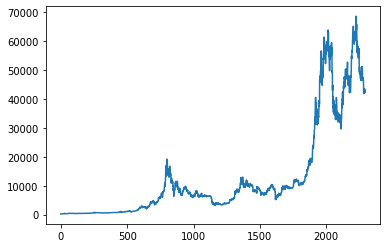

In [12]:
data_close = data['Close']
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
data_close = scaler.fit_transform(data_close)
data_close

array([[0.00000000e+00],
       [2.79721714e-05],
       [3.95418129e-05],
       ...,
       [6.26500191e-01],
       [6.21121625e-01],
       [6.14997624e-01]])

In [15]:
# split data into train and test
train_size = int(len(data_close)*0.7)
test_size = len(data_close) - train_size

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  1605 689


In [16]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [17]:
trainX

array([[0.00000000e+00, 2.79721714e-05, 3.95418129e-05, ...,
        3.14869992e-05, 1.08373858e-04, 1.60949824e-04],
       [2.79721714e-05, 3.95418129e-05, 7.87907235e-05, ...,
        1.08373858e-04, 1.60949824e-04, 1.99027125e-04],
       [3.95418129e-05, 7.87907235e-05, 3.14869992e-05, ...,
        1.60949824e-04, 1.99027125e-04, 3.86631060e-04],
       ...,
       [1.45340034e-01, 1.36685063e-01, 1.38761301e-01, ...,
        1.39916801e-01, 1.39757902e-01, 1.36910745e-01],
       [1.36685063e-01, 1.38761301e-01, 1.38276987e-01, ...,
        1.39757902e-01, 1.36910745e-01, 1.30435260e-01],
       [1.38761301e-01, 1.38276987e-01, 1.39916801e-01, ...,
        1.36910745e-01, 1.30435260e-01, 1.24299542e-01]])

In [18]:
trainX[0]

array([0.00000000e+00, 2.79721714e-05, 3.95418129e-05, 7.87907235e-05,
       3.14869992e-05, 1.08373858e-04, 1.60949824e-04])

In [24]:
trainY

array([[ 257.19,  270.  ,  269.26, ..., 9150.  , 8731.04, 8846.  ]])

In [26]:
trainY[0]

array([ 257.19,  270.  ,  269.26, ..., 9150.  , 8731.04, 8846.  ])

In [19]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

Epoch 1/100
50/50 [==============================] - 2s 5ms/step - loss: 9.0344e-04
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 3.1255e-04
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 6.8288e-05
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 4.4146e-05
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 4.4720e-05
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 4.4150e-05
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 4.4562e-05
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 4.3981e-05
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 4.5403e-05
Epoch 10/100
50/50 [==============================] - 0s 6ms/step - loss: 4.3671e-05
Epoch 11/100
50/50 [==============================] - 0s 5ms/step - loss: 4.4659e-05
Epoch 12/100
50/50 [==============================] - 0s 4ms/step - loss: 

50/50 [==============================] - 0s 4ms/step - loss: 2.9291e-05
Epoch 98/100
50/50 [==============================] - 0s 3ms/step - loss: 2.8534e-05
Epoch 99/100
50/50 [==============================] - 0s 3ms/step - loss: 2.9512e-05
Epoch 100/100
50/50 [==============================] - 0s 3ms/step - loss: 2.8747e-05


In [21]:
# test the model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [22]:
# Calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 359.53528491686234
Test score: %.2f rmse 3769.7538161935463


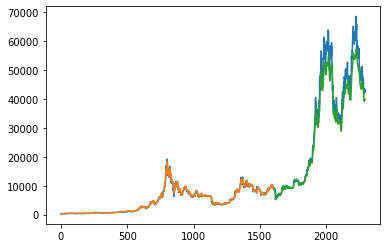

In [23]:
# Plot the predictions on a graph
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()